### **CÁC PHẦN** 
- Import các tư viện cần thiết và viết các hàm cần thiết.
- Loading dataset vào trong biến.
- In ra biểu đồ phân tán thể hiện mối tương quan giữa các input với output.
- Mã hóa và phân chia dữ liệu.
- Sử dụng hồi quy đa biến thông thường để tính toán dự đoán kết quả => chứng sự ảnh hưởng của overfitting.
- Ridge Regression
  - Tìm ra model hồi quy có giá trị rMSE tốt nhất.
  - Tìm model hồi quy có giá trị R2 tốt nhất.
  - Load 2 model trên và tính toán hiệu năng.
  - Dự đoán giá ICO.
- Neural Network
  - Tìm ra model NN có giá trị rMSE tốt nhất.
  - Tìm model NN có giá trị R2 tốt nhất.
  - Load 2 model trên và tính toán hiệu năng.
  - Dự đoán giá ICO.

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%cd /content/drive/MyDrive/DoAn2/ICO_FINAL

/content/drive/MyDrive/DoAn2/ICO_FINAL


### **CÁC THƯ VIỆN VÀ FUNCTION CẦN THIẾT.**

### **CÁC THƯ VIỆN**

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)
from matplotlib.animation import FuncAnimation
#plt.style.use('ggplot')
import pandas as pd
from math import sqrt

In [2]:
from enum import Enum
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import os
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from sklearn.preprocessing import OneHotEncoder
#from sklearn.externals import joblib
import joblib
from sklearn import decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor 

In [9]:
class LineaReggressionMetrics(Enum):
    R_SQUARED = 1
    ROOT_MEAN_SQUARED_ERROR = 2
    MEAN_ABSOLUTE_ERROR = 3

class Solvers(Enum):
    lbfgs = 1
    sgd = 2
    adam = 3

def load_Dataset1(dataset = 'D:/Tunf/NOO/HK1_2022_2023_(Ki1_nam4)/DA2/ICO_FINAL/DATA/ico_data_final.csv'):
    all_data = np.genfromtxt(fname=dataset, names=True, delimiter=',')
    #Lấy hết toàn bộ header trong dataset trả về kiểu chuỗi    
    featureNames = all_data.dtype.names[1:-1] 
    #Lấy hết toàn bộ tên của ico.
    ico_names = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1, usecols=0, dtype=str)
    #Lấy hết toàn bộ giá trị trong dataset trừ header và tên ico
    all_data = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:]
    #Lấy hết giá trị thuộc các thành phần output
    x = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,1:-1]
    #Lấy hết giá trị output
    y = np.genfromtxt(fname=dataset, delimiter=',',skip_header=1)[:,-1]
    return (featureNames,x,y,ico_names)
def load_Dataset2(
    path = 'D:/Tunf/NOO/HK1_2022_2023_(Ki1_nam4)/DA2/ICO_FINAL/DATA/ico_data_final.csv'):
    #path = '/content/drive/MyDrive/DoAn2/ICO_FINAL/DATA/ico_data_final.csv'):    
      dataset = pd.read_csv(path)
      x= dataset.iloc[:, 1:-1].values 
      data_com = dataset.iloc[:,1:14].values
      print(data_com)
      #Lấy giá trị cột cuối
      y= dataset.iloc[:,13].values
      icoNames = dataset.iloc[:,0]
      featureNames = list(dataset.columns[1:-1])
      return (featureNames, x, y, icoNames, data_com)

In [10]:
def createFolderIfDoesntExist(folderName):
    exists = os.path.isdir(folderName)
    if not exists:
        os.makedirs(folderName)
        
    return exists
def loadModel(fileName):
    exists = os.path.isfile(fileName)
    if exists:    
        # Tải model nếu nó tồn tại
        return joblib.load(fileName)
    else:
        return None

# Tải dataset từ Github
def loadDataFromGithub(fileName='./DATA/ico_data_final.csv'):
    exists = os.path.isfile(fileName)
    if not exists:
      command = "wget https://raw.githubusercontent.com/daominhthuan42/FINAL-PROJECT/master/FINAL_PROJECT/FINAL_PROJECT/ico_data_final.csv -P ./DATASET/"

In [11]:
def createResultsFolderIfDoesntExist(folder):
    folderExists = createFolderIfDoesntExist(folder)
    #if not folderExists:
      #download best models from github - mainly for google colab
     # !wget https://github.com/daominhthuan42/FINAL-PROJECT/blob/master/FINAL_PROJECT/BEST_MODEL/bestRegressionModel_Ridge_MEAN_ABSOLUTE_ERROR.sav?raw=true -P "./RESULT/"
     # !wget https://github.com/daominhthuan42/FINAL-PROJECT/blob/master/FINAL_PROJECT/BEST_MODEL/bestRegressionModel_Ridge_ROOT_MEAN_SQUARED_ERROR.sav?raw=true -P "./RESULT/" 
     # !wget https://github.com/daominhthuan42/FINAL-PROJECT/blob/master/FINAL_PROJECT/BEST_MODEL/bestRegressionModel_Ridge_R_SQUARED.sav?raw=true -P "./RESULT/"       

In [12]:
"""
HÀM NÀY LÀ SẼ IN RA PLOT MONG MUỐN VÀ PLOT DỰ ĐOÁN
"""
def plotExpectedVsPredictedOutput(y_test, y_pred, fileName='', saveToFile=False):
    fig, ax = plt.subplots(figsize=(10,10))
    ax.scatter(y_test, y_pred, c = "blue", label = "y_pred")
    ax.plot([y_pred.min(), y_pred.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
    ax.set_xlabel('Measured')
    ax.set_ylabel('Predicted')
    ax.legend(loc="upper left")
    plt.xlim(-10, 10)
    plt.ylim(-10, 10)
    plt.title(fileName)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_RESULT/")
        plt.savefig('IMAGE_RESULT/'+fileName+".png", dpi = 300)
    else: 
        plt.show()

In [13]:
"""
HÀM NÀY LÀ SẼ IN RA PLOT MONG MUỐN VÀ PLOT DỰ ĐOÁN
"""
def plotExpectedVsPredictedOutput2(y_test, y_pred, fileName='', saveToFile = True):
    plt.subplots(figsize=(6,6))    
    plt.xlabel('y_pred')
    plt.ylabel('y_test_holdout')   
    sns.regplot(y_pred, y_test, ci = None)    
    plt.title(fileName)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_RESULT/")
        plt.savefig('IMAGE_RESULT/'+fileName+".png", dpi = 300)    
    plt.show()

In [14]:
def line_plot(line1, line2, label1= 'actual', label2= 'prediction', title='', lw=2, saveToFile = True):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1,'-o',  color='darkorange', label=label1, linewidth=lw)
    ax.plot(line2, '-s', color='navy', label=label2, linewidth=lw)   
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if(saveToFile == True):
        createFolderIfDoesntExist("IMAGE_LINE_PLOT/")
        plt.savefig('IMAGE_LINE_PLOT/'+title+".png", dpi = 500)
    plt.show()

def line_plot2(line, lw = 2, saveToFile= True, title='', label1=''):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(line,  color='darkorange', label=label1, linewidth=lw)    
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if(saveToFile == True):
        createFolderIfDoesntExist("OPTIMIZE/")
        plt.savefig('OPTIMIZE/'+title+".png", dpi = 300)
    plt.show()

def plotResult(y_test_hodlout, y_pred_rMSE, y_pred_R2, y_pred_MAE, saveToFile = True, rMSE = '', R2= '', MAE = ''):
  f, ax = plt.subplots(figsize=(10, 7), nrows=3)  
  f.tight_layout()
  ax[0].plot(range(len(y_pred_rMSE)), y_pred_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[0].plot(range(len(y_pred_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[0].set_title("Predicted vs Actuals Using Best model rMSE: " + rMSE)
  ax[0].legend(loc='best')

  ax[1].plot(range(len(y_pred_R2)), y_pred_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[1].plot(range(len(y_pred_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[1].set_title("Predicted vs Actuals Using Best model R2: "+R2)
  ax[1].legend(loc='best')

  ax[2].plot(range(len(y_pred_MAE)), y_pred_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[2].plot(range(len(y_pred_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[2].set_title("Predicted vs Actuals Using Best model MAE: "+ MAE)
  ax[2].legend(loc='best')
  if(saveToFile == True):
      createFolderIfDoesntExist("LINE_PLOT_3/")
      plt.savefig('LINE_PLOT_3/'+"PLOT_RESULT"+".png", dpi = 300)

In [58]:
def plotResult2(y_test_hodlout, y_pred_RF_rMSE, y_pred_RF_R2, y_pred_RF_MAE, y_pred_Ridge_rMSE, 
                y_pred_Ridge_R2, y_pred_Ridge_MAE, saveToFile = True):
  #f, ax = plt.subplots(figsize=(5.1866666666666665, 6.333333333333333), nrows=6)
  f, ax = plt.subplots(figsize=(15, 10), nrows=6)   
  f.tight_layout()
  ax[0].plot(range(len(y_pred_RF_rMSE)), y_pred_RF_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[0].plot(range(len(y_pred_RF_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[0].set_title("Predicted vs Actuals Using Best model rMSE RF")
  ax[0].legend(loc='best')

  ax[1].plot(range(len(y_pred_RF_R2)), y_pred_RF_R2, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[1].plot(range(len(y_pred_RF_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[1].set_title("Predicted vs Actuals Using Best model R2 RF")
  ax[1].legend(loc='best')

  ax[2].plot(range(len(y_pred_RF_MAE)), y_pred_RF_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[2].plot(range(len(y_pred_RF_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[2].set_title("Predicted vs Actuals Using Best model MAE RF")
  ax[2].legend(loc='best')

  ax[3].plot(range(len(y_pred_Ridge_rMSE)), y_pred_Ridge_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[3].plot(range(len(y_pred_Ridge_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[3].set_title("Predicted vs Actuals Using Best model rMSE Ridge " )
  ax[3].legend(loc='best')

  ax[4].plot(range(len(y_pred_Ridge_R2)), y_pred_Ridge_R2, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[4].plot(range(len(y_pred_Ridge_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[4].set_title("Predicted vs Actuals Using Best model R2 Ridge " )
  ax[4].legend(loc='best')

  ax[5].plot(range(len(y_pred_Ridge_MAE)), y_pred_Ridge_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1)
  ax[5].plot(range(len(y_pred_Ridge_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1)
  ax[5].set_title("Predicted vs Actuals Using Best model MAE Ridge " )
  ax[5].legend(loc='best')  
  if(saveToFile.all()):
      createFolderIfDoesntExist("LINE_PLOT_6/")
      plt.savefig('LINE_PLOT_6/'+"PLOT_RESULT_RF_vs_RIDGE_6"+".png", dpi = 300)

In [47]:
def plotResult3(y_test_hodlout, y_pred_Ridge_rMSE, y_pred_Ridge_R2, y_pred_Ridge_MAE, y_pred_NN_rMSE, 
                y_pred_NN_R2, y_pred_NN_MAE, saveToFile = True, solver = Solvers.lbfgs):
  #f, ax = plt.subplots(figsize=(5.1866666666666665, 6.333333333333333), nrows=6)
  f, ax = plt.subplots(figsize=(15, 10), nrows=6)   
  f.tight_layout()
  ax[0].plot(range(len(y_pred_Ridge_rMSE)), y_pred_Ridge_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[0].plot(range(len(y_pred_Ridge_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[0].set_title("Predicted vs Actuals Using Best model rMSE Ridge")
  ax[0].legend(loc='best')

  ax[1].plot(range(len(y_pred_Ridge_R2)), y_pred_Ridge_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[1].plot(range(len(y_pred_Ridge_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[1].set_title("Predicted vs Actuals Using Best model R2 Ridge")
  ax[1].legend(loc='best')

  ax[2].plot(range(len(y_pred_Ridge_MAE)), y_pred_Ridge_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[2].plot(range(len(y_pred_Ridge_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[2].set_title("Predicted vs Actuals Using Best model MAE Ridge")
  ax[2].legend(loc='best')

  ax[3].plot(range(len(y_pred_NN_rMSE)), y_pred_NN_rMSE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[3].plot(range(len(y_pred_NN_rMSE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[3].set_title("Predicted vs Actuals Using Best model rMSE NN " + str(solver.name))
  ax[3].legend(loc='best')

  ax[4].plot(range(len(y_pred_NN_R2)), y_pred_NN_R2, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[4].plot(range(len(y_pred_NN_R2)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[4].set_title("Predicted vs Actuals Using Best model R2 NN " + str(solver.name))
  ax[4].legend(loc='best')

  ax[5].plot(range(len(y_pred_NN_MAE)), y_pred_NN_MAE, '-s', color='navy', label='Predicted Values', linewidth = 1);
  ax[5].plot(range(len(y_pred_NN_MAE)), y_test_hodlout, '-o', color='darkorange', label='Actual Values', linewidth = 1);
  ax[5].set_title("Predicted vs Actuals Using Best model MAE NN " + str(solver.name))
  ax[5].legend(loc='best')  
  if(saveToFile == True):
      createFolderIfDoesntExist("LINE_PLOT_6/")
      plt.savefig('LINE_PLOT_6/'+"PLOT_RESULT"+".png", dpi = 300)

In [16]:
def plotPredicted(rMSE, R2, MAE):
  plt.figure(figsize=(10, 5))
  ax1 = plt.subplot(311, title ='Price ICO 0x, modum and crypto20 using best model rMSE')
  ax1.hist(rMSE)
  ax2 = plt.subplot(312,sharex=ax1, title ='Price ICO 0x, modum and crypto20 using best model R2')
  ax2.hist(R2)
  ax3 = plt.subplot(313,sharex=ax1, title ='Price ICO 0x, modum and crypto20 using best model MAE')
  ax3.hist(MAE)
  plt.tight_layout()

In [17]:
def printPlotCoef(feauteNames, model):
    d = model.coef_[0:12]
    print("Hệ số: ", d)
    print("Input: ", feauteNames) 
    data = { feauteNames[0]: d[0], feauteNames[1]: d[1], feauteNames[2]: d[2], feauteNames[3]: d[3], feauteNames[4]: d[4], feauteNames[5]: d[5], feauteNames[6]: d[6],
            feauteNames[7]: d[7], feauteNames[8]: d[8], feauteNames[9]: d[9], feauteNames[10]: d[10], feauteNames[11]: d[11]}  
    coef = pd.Series(data)
    plt.figure(figsize=(10, 5))
    plt.xlim(-1, 1)
    plt.ylim(-1, 1)
    coef.head(12).plot(kind='bar')
    plt.title('Feature Significance')
    plt.tight_layout()    

In [18]:
"""
HÀM TÍNH TOÁN DỰ ĐOÁN KẾT QUẢ
"""        
def makePrediction(model,example_to_predict):
    encoded_x, encodedCategoryArray = encodeSingleElement(x,example_to_predict)
    y_pred = model.predict(encoded_x.reshape(1, -1))
    
    return y_pred

"""
HÀM TÍNH TOÁN RA HỆ SỐ TƯƠNG QUAN GIỮA CÁC BIẾN VÀ SỬ DỤNG BIỂU ĐỒ
PHÂN TÁN ĐỂ THỂ HIỆN SỰ TUYẾN TÍNH GIỮA 2 BIẾN.
"""
def getCovarianceMatrixAndPrintScatterPlot(x, y, saveToFile=True):
    nrows = x.shape[0] #trả về sô hàng
    ncols = x.shape[1] # trả về số vột 

    for i in np.arange(ncols):
        corCoef = np.corrcoef(x[:,i], y) 
        plt.xlabel(featureNames[i])
        plt.ylabel("Price after 6 months ($) ")
        plt.suptitle('Scatter Plot of feature {:s} vs Price after 6 months'.format(featureNames[i]))
        corr = "Correlation Coefficient: "+str(corCoef[0,1])
        plt.title(corr)
        plt.scatter(x[:,i], y)
        if(saveToFile == True):
            exist= createFolderIfDoesntExist("IMAGE_SCATTER/")
            plt.savefig('IMAGE_SCATTER/{:s}_vs_Price_scatter_plot.png'.format(featureNames[i]), dpi = 300)                    
            plt.show()
        
        plt.clf() 

### **LOADING ICO DATASET VÀO TRONG BIẾN**

In [19]:
(featureNames, x, y, icoNames, data_com) = load_Dataset2()


[[1.7145600e+00 1.9931000e-04 1.0000000e+09 ... 9.0000000e+00
  1.8200000e+02 1.0800000e+00]
 [1.2293200e+00 1.4290000e-04 2.0000000e+07 ... 1.0000000e+00
  2.8000000e+01 2.1900000e+00]
 [2.3553500e-01 2.7380000e-05 1.3027102e+08 ... 1.6000000e+01
  5.1000000e+01 9.0026900e-01]
 ...
 [1.0328300e+00 1.2006000e-04 9.9218023e+07 ... 2.8000000e+01
  1.5500000e+02 2.8900000e+00]
 [6.7163900e+00 7.8075000e-04 2.1000000e+08 ... 3.0000000e+00
  1.8200000e+02 3.2000000e+00]
 [2.5667400e-01 2.9840000e-05 1.8500000e+09 ... 1.5000000e+01
  2.9000000e+01 2.7435000e-01]]


### **HỆ SỐ TƯƠNG QUAN GIỮA CÁC INPUT VỚI OUTPUT**
Hệ số tương quan thê hiển độ quan hệ tuyến tính giữa 2 biến không phân biệt biến này phụ thuộc biến kia.

**Đặc tính:**
 - Hệ số tương quan không có đơn vị.
 - Nằm trong khoàng [-1,1].

  ![alt text](https://i.imgur.com/72RWtXW.png)
 - r > 0: Tương quan dương.
 - r < 0: Tương quan âm.
 - r = 0: Không tương quan.
 Đánh giá tương quan giữa 2 biến định lượng.

 ![alt text](https://i.imgur.com/JpGBUGC.png)

 

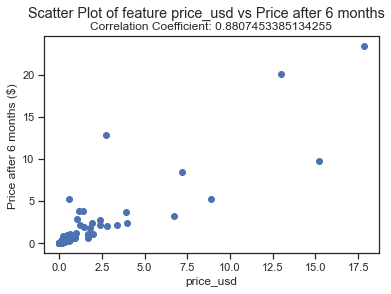

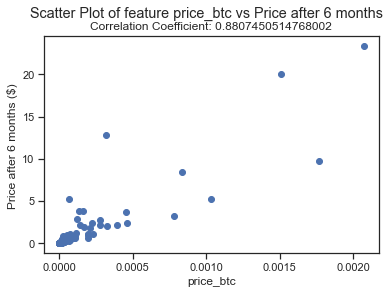

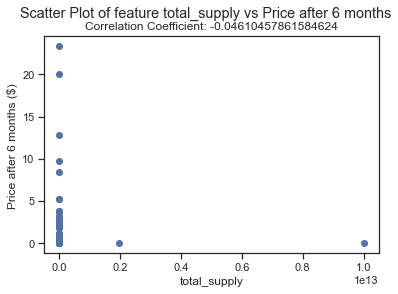

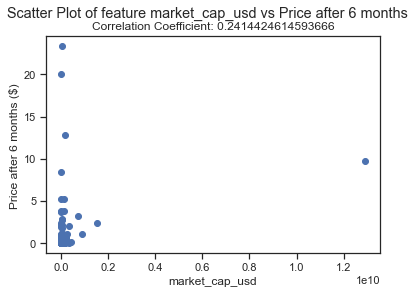

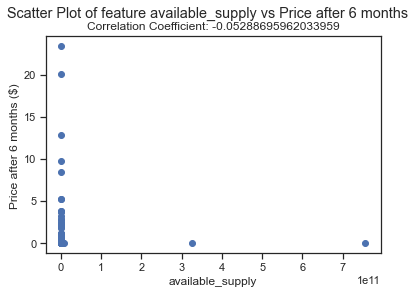

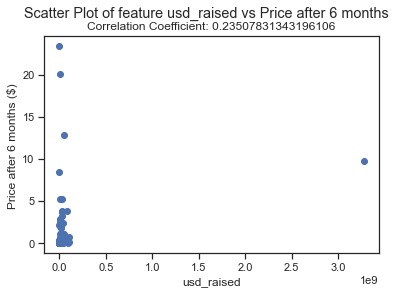

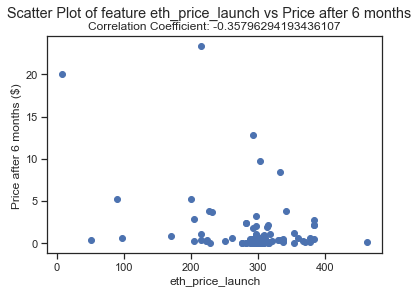

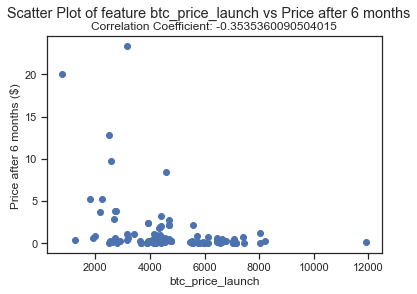

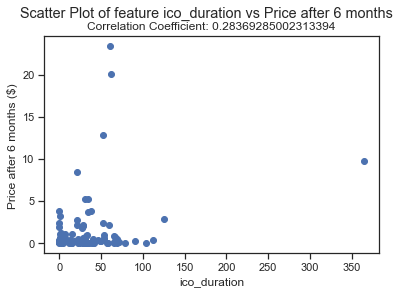

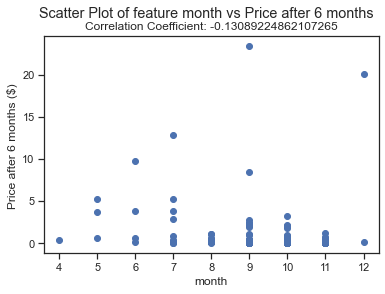

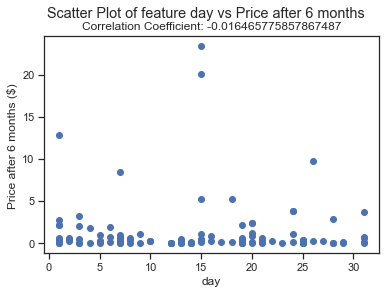

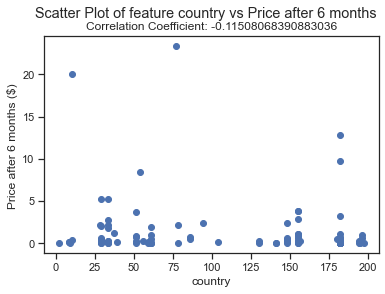

<Figure size 432x288 with 0 Axes>

In [20]:
getCovarianceMatrixAndPrintScatterPlot(x, y)

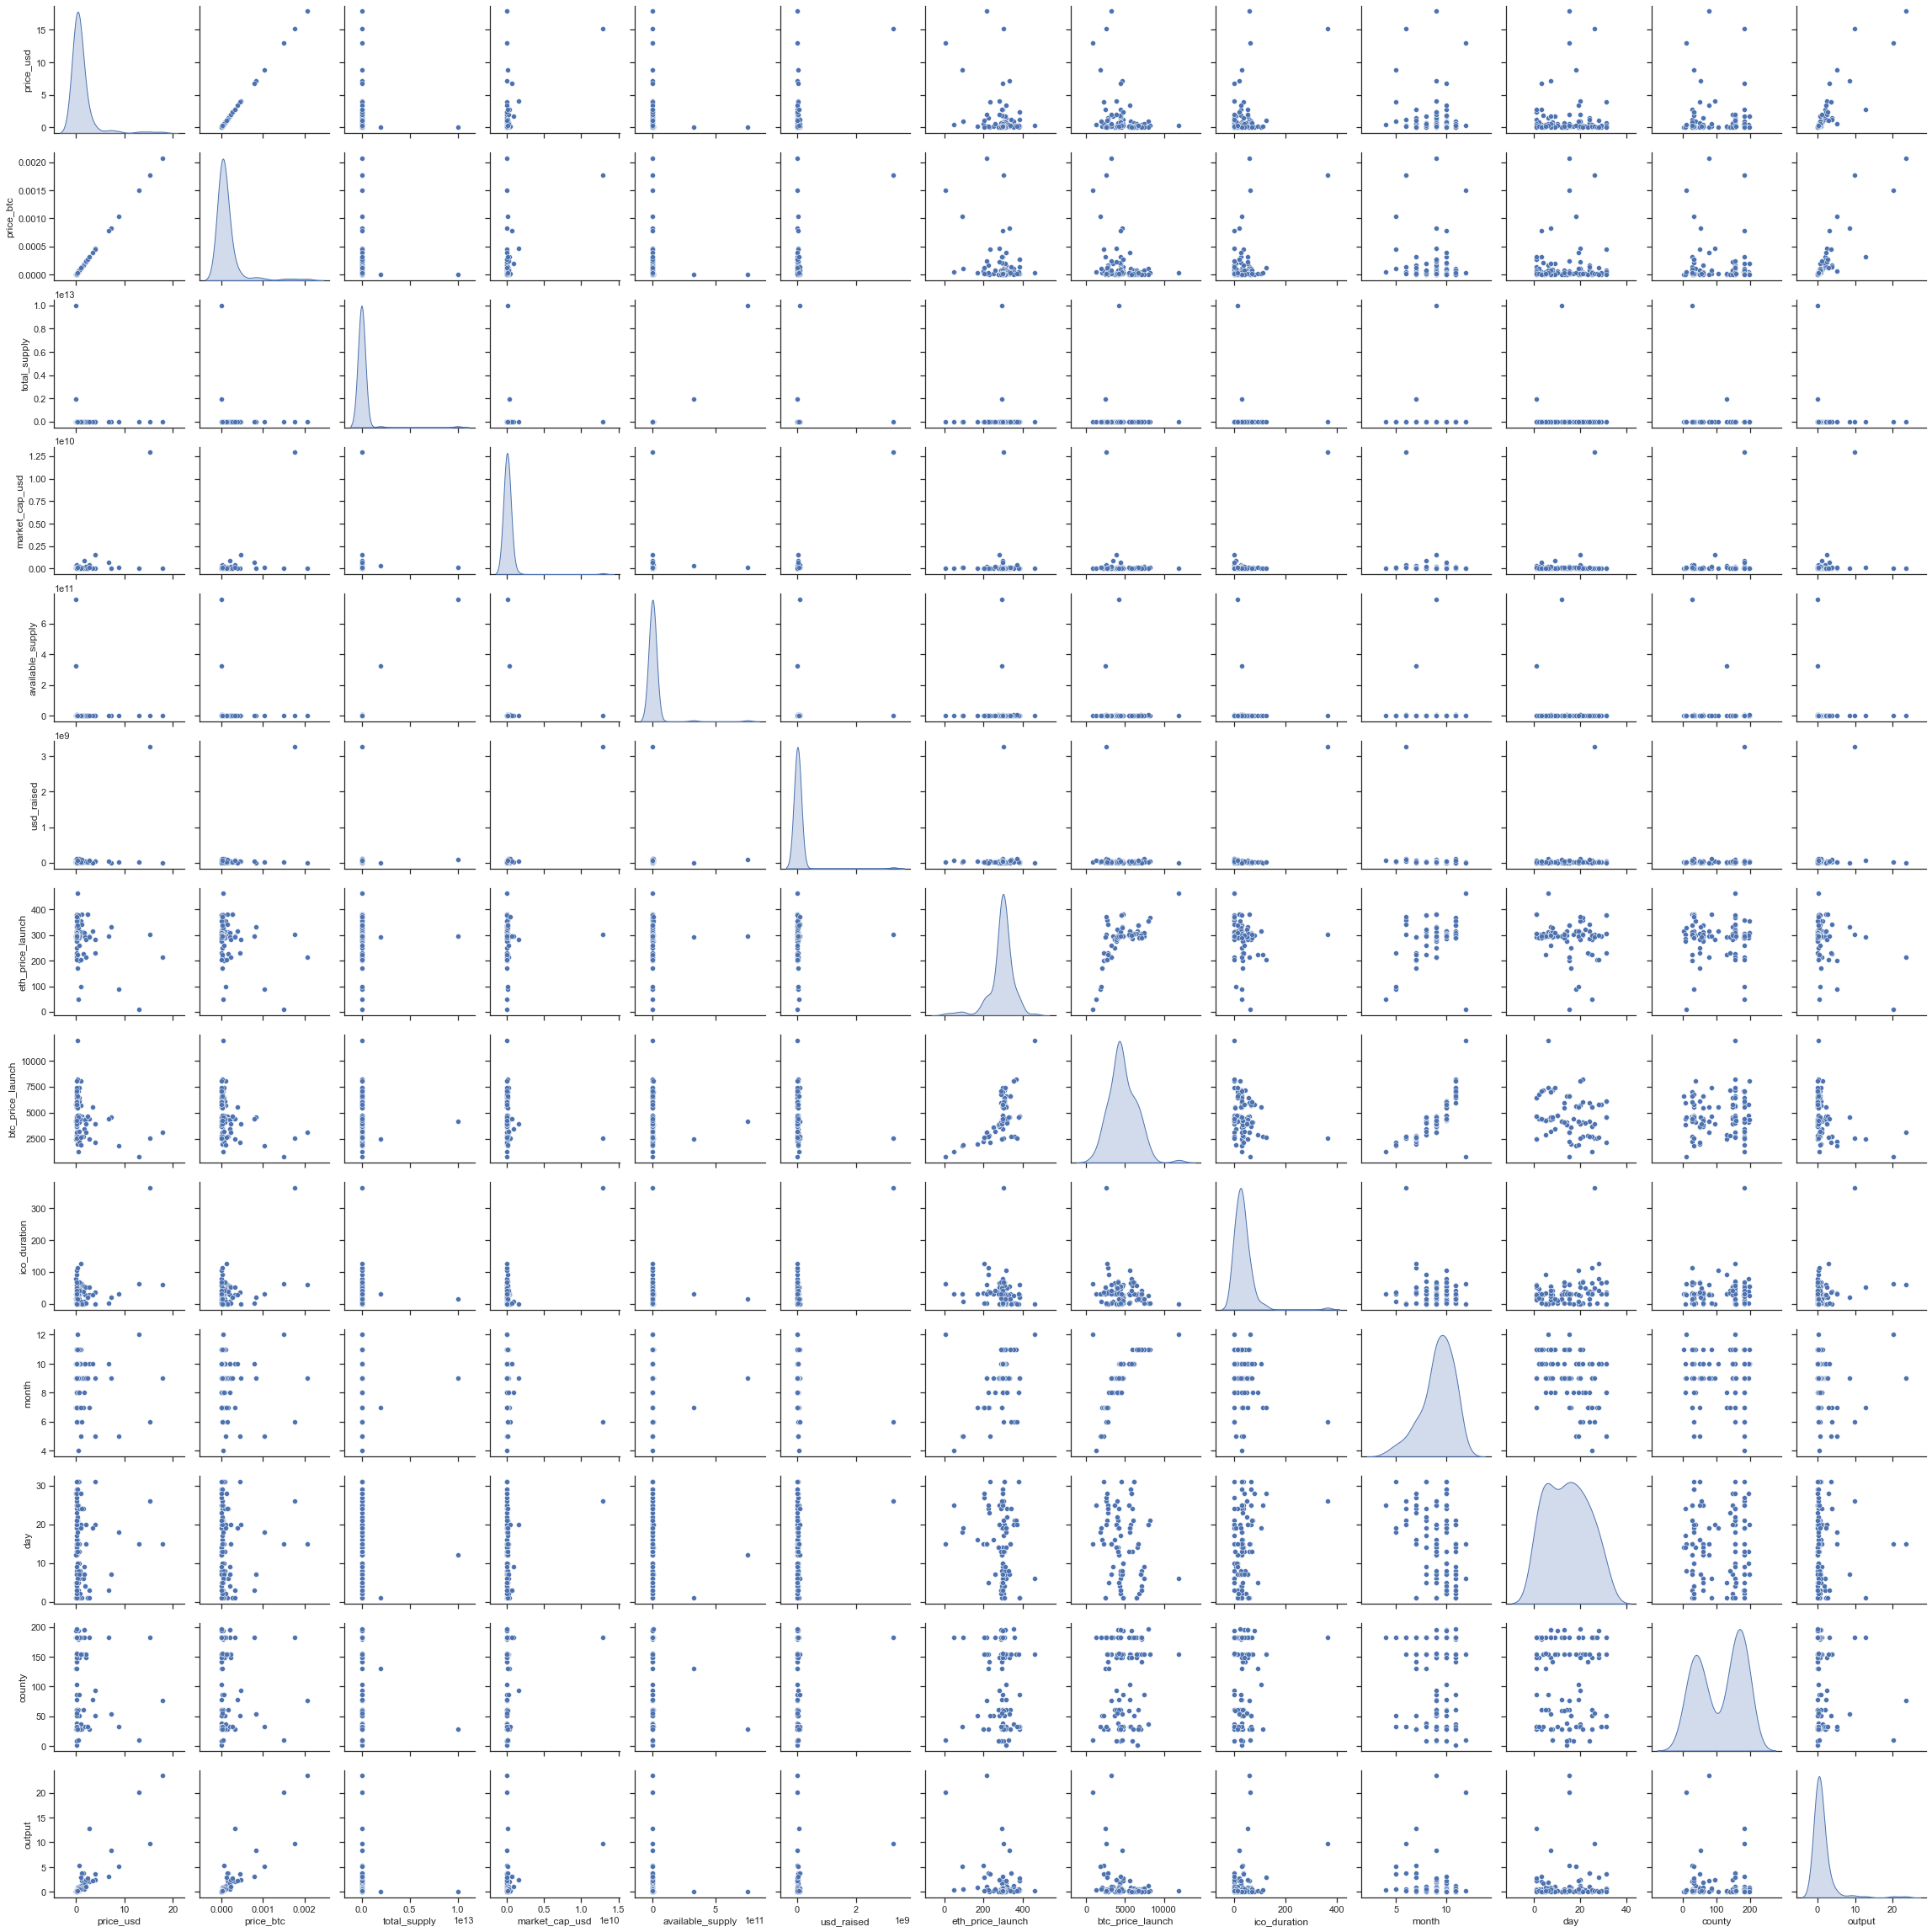

In [21]:
data = pd.DataFrame(data_com, columns= ['price_usd', 'price_btc', 'total_supply', 'market_cap_usd', 'available_supply', 'usd_raised', 'eth_price_launch',
                                        'btc_price_launch', 'ico_duration',
                                        'month','day','county', 'output'])
g = sns.pairplot(data, palette="husl",  diag_kind="kde")

In [23]:
data.corr(method ='pearson') 

,price_usd,price_btc,total_supply,market_cap_usd,available_supply,usd_raised,eth_price_launch,btc_price_launch,ico_duration,month,day,county,output
price_usd,1.000000,1.000000,-0.047814,0.503084,-0.054590,0.479698,-0.322412,-0.317538,0.425071,-0.147879,0.013461,-0.090223,0.880745
price_btc,1.000000,1.000000,-0.047813,0.503085,-0.054589,0.479698,-0.322411,-0.317548,0.425073,-0.147886,0.013466,-0.090227,0.880745
total_supply,-0.047814,-0.047813,1.000000,-0.002462,0.977296,0.011378,0.005762,-0.052650,-0.048683,-0.035144,-0.052377,-0.113814,-0.046105
market_cap_usd,0.503084,0.503085,-0.002462,1.000000,0.000644,0.989104,0.017250,-0.138064,0.750553,-0.203643,0.110983,0.108991,0.241442
available_supply,-0.054590,-0.054589,0.977296,0.000644,1.000000,0.007976,0.006848,-0.075307,-0.047647,-0.060710,-0.079563,-0.100746,-0.052887
usd_raised,0.479698,0.479698,0.011378,0.989104,0.007976,1.000000,0.015393,-0.127289,0.770750,-0.204329,0.131001,0.099634,0.235078
eth_price_launch,-0.322412,-0.322411,0.005762,0.017250,0.006848,0.015393,1.000000,0.615691,-0.126158,0.395058,-0.183897,-0.000494,-0.357963
btc_price_launch,-0.317538,-0.317548,-0.052650,-0.138064,-0.075307,-0.127289,0.615691,1.000000,-0.187037,0.798111,-0.192610,0.055256,-0.353536
ico_duration,0.425071,0.425073,-0.048683,0.750553,-0.047647,0.770750,-0.126158,-0.187037,1.000000,-0.173011,0.212072,0.086277,0.283693
month,-0.147879,-0.147886,-0.035144,-0.203643,-0.060710,-0.204329,0.395058,0.798111,-0.173011,1.000000,-0.357802,-0.022890,-0.130892


[Text(0.5, 0, 'price_usd'),
 Text(1.5, 0, 'price_btc'),
 Text(2.5, 0, 'total_supply'),
 Text(3.5, 0, 'market_cap_usd'),
 Text(4.5, 0, 'available_supply'),
 Text(5.5, 0, 'usd_raised'),
 Text(6.5, 0, 'eth_price_launch'),
 Text(7.5, 0, 'btc_price_launch'),
 Text(8.5, 0, 'ico_duration'),
 Text(9.5, 0, 'month'),
 Text(10.5, 0, 'day'),
 Text(11.5, 0, 'county'),
 Text(12.5, 0, 'output')]

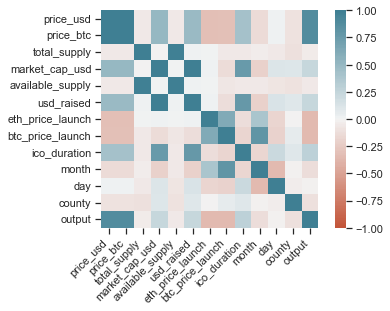

In [24]:
corr = data.corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

In [25]:
"""
MÃ HÓA VÀ PHÂN LOẠI DỮ LIỆU VÀ PHÂN LOẠI DỮ LIỆU
"""
def encodeData(x):
    enc = OneHotEncoder(handle_unknown='error', sparse=False)
    # Mã hóa one hot cho 4 4 trường dữ liệu ICO Date, ICO month launched and ICO country.
    encodedCategoryArray= enc.fit_transform(x[:,8:12])
    # Loại bỏ 4 trường dữ liệu đó từ dataset.
    allInputsExceptCategorical = np.delete(x, np.s_[8:12], axis=1)
    # Ghép các input còn lại với các trường mã hóa.
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategoryArray),axis=1)
    print("Đây là hàm con 1 print(encodedCategoryArray:")
    print(encodedCategoryArray)
    return encodedX

def encodeSingleElement(x, sample):
    enc = OneHotEncoder(handle_unknown='error', sparse=False)

    encodedCategoryArray= enc.fit(x[:,8:12])
    allInputsExceptCategorical = np.delete(sample, np.s_[8:12], axis=0)
    
    encodedCategories  = enc.transform(sample[8:12].reshape(1, -1))
    encodedX = np.concatenate((allInputsExceptCategorical,encodedCategories.flatten()),axis=0)
    return (encodedX, encodedCategoryArray)

In [26]:
encodeX = encodeData(x)
print("data sau khi onehotencoding:")
print(encodeX)

Đây là hàm con 1 print(encodedCategoryArray:
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
data sau khi onehotencoding:
[[1.7145600e+00 1.9931000e-04 1.0000000e+09 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [1.2293200e+00 1.4290000e-04 2.0000000e+07 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.3553500e-01 2.7380000e-05 1.3027102e+08 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 ...
 [1.0328300e+00 1.2006000e-04 9.9218023e+07 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [6.7163900e+00 7.8075000e-04 2.1000000e+08 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]
 [2.5667400e-01 2.9840000e-05 1.8500000e+09 ... 0.0000000e+00
  0.0000000e+00 0.0000000e+00]]


### **CHIA DATASET THÀNH TẬP TRAIN VÀ TẬP TEST**
80% cho tập train và 20% cho tập test. Sau đó trong tập train cũng chia 80/20 để tính toán.

In [27]:
X_cross, X_test_holdout, y_cross, y_test_holdout = train_test_split(encodeX, y, test_size=0.2, random_state = 42)

# **Random Forest**

---


Chia dữ liệu thành 80/20 từ trập train Ridge Regression

In [40]:
from sklearn.ensemble import RandomForestRegressor
def RFRegression1(x, y):       
    X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    regressor_RF = RandomForestRegressor(n_estimators=100, random_state=5)
    regressor_RF.fit(X_train, y_train) 

    #bestRegressionCoef_RF = regressor_RF.score(X_train, y_train)  
    bestRegressionCoef_RF = regressor_RF.feature_importances_  

    y_pred_RF = regressor_RF.predict(X_val)
    
    r2_RF = r2_score(y_val, y_pred_RF)    
    rMeanSquaredError_RF = sqrt(mean_squared_error(y_val, y_pred_RF))
    meanAbsoluteError = mean_absolute_error(y_val, y_pred_RF)  
      
    return (regressor_RF, rMeanSquaredError_RF, r2_RF, meanAbsoluteError, bestRegressionCoef_RF)

In [29]:
def Optimize_RF(metricToOptimize, numIterations, x, y, showOutput = True):
     
    # GIÁ TRỊ R2, rMSE, MAE CỦA HỒI QUY RF
    maxRSquared_RF = -10000
    rMSEMin_RF = 10000
    meanABError_min = 10000   

    crossValidationMeanSquaredError = 1
    crossValidationMeanAbsoluteError = 1
    crossValidationR2Squared = 1
    bestRFModel = None

    plotrMSE = []
    plotR2 = []
    plotMAE = []  

    # HỆ SỐ HỒI QUY KHI SỬ DỤNG HỒI QUY RF   
    bestRegressionCoef_temp_RF = np.array([])
    bestRegressionCoef_rMSE_RF = np.array([])
    bestRegressionCoef_R2_RF = np.array([])
    bestRegressionCoef_MAE_RF = np.array([])    

    for i in np.arange(numIterations):
        bestRegression_RF, rootMeanSquaredError_RF, rSquared_RF, meanAbsoluteError, bestRegressionCoef_temp_RF  = RFRegression1(x, y)
              
#       TÌM GIÁ TRỊ rMSE TỐT NHẤT
        if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
            if(rootMeanSquaredError_RF < rMSEMin_RF):
                rMSEMin_RF = rootMeanSquaredError_RF              
                crossValidationMeanSquaredError = rootMeanSquaredError_RF
                plotrMSE.append(rootMeanSquaredError_RF)               
                bestRegressionCoef_rMSE_RF = bestRegressionCoef_temp_RF 
                bestRFModel = bestRegression_RF
            if(showOutput):
                print(i," bestrMSE: ", rMSEMin_RF)

        elif(metricToOptimize == LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR):
            if(meanAbsoluteError < meanABError_min):
                meanABError_min = meanAbsoluteError
                plotMAE.append(meanAbsoluteError)                             
                bestRegressionCoef_MAE_RF = bestRegressionCoef_temp_RF
                crossValidationMeanAbsoluteError = meanAbsoluteError
                bestRFModel = bestRegression_RF                   
            if(showOutput):
                print(i," bestrMAE: ", meanABError_min)                      
#      Tìm GIÁ TRỊ R2 TỐT NHẤT
        else:
            if(rSquared_RF > maxRSquared_RF and rSquared_RF > 0):
                maxRSquared_RF = rSquared_RF               
                bestRegressionCoef_R2_RF = bestRegressionCoef_temp_RF
                plotR2.append(rSquared_RF)  
                crossValidationR2Squared = rSquared_RF
                bestRFModel = bestRegression_RF                  
            if(showOutput):
                print(i,"bestRSquared:",maxRSquared_RF)   
   
   
          
    if(metricToOptimize == LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR):
        print(" \n Fistround best rMSE: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(rMSEMin_RF,numIterations))
        print("Value alpha: ", bestRFModel.ccp_alpha)     
        line_plot2(plotrMSE, title='Optimize value rMSE on validation data - RF', 
                   label1='rMSE')      
        
    elif(metricToOptimize == LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR):
        print(" \n Fistround best MAE: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(meanABError_min,numIterations))
        print("Value alpha: ", bestRFModel.ccp_alpha)    
        line_plot2(plotMAE, title='Optimize value MAE on validation data - RF',
                    label1='MAE')    
    else: 
       print(" \n Fistround best RSquared: {:f} \n ,after running linear regression {:d} different times with different test and training combinations"
              .format(maxRSquared_RF,numIterations))
       print("Value alpha: ", bestRFModel.ccp_alpha)    
       line_plot2(plotR2, title='Optimize value R2 on validation data - RF', 
                   label1='R2')   
     
    if(showOutput):
        print(" \n Fistround Best regression coef rMSE: ", bestRegressionCoef_rMSE_RF,"\n")
        print(" \n Fistround Best regression coef R2: ", bestRegressionCoef_R2_RF,"\n")
        print(" \n FistroundBest regression coef MAE: ", bestRegressionCoef_MAE_RF,"\n")
    
    fileName_RF = "RESULT/" + "bestRegressionModel_RF_" + str(metricToOptimize.name) + ".sav"   
    saveBestModel(bestRFModel, fileName_RF)   

In [32]:
ico_0x = np.array([1.71456, 0.00019931, 1000000000, 905793616, 528295082, 24000000, 297.63, 3420.4, 7, 8, 9, 182])
ico_modum = np.array([2.36319, 0.00027471, 27266200, 43166501, 18266200, 13500000, 383.47, 4701.76, 21, 9, 1, 33])
ico_crypto20 = np.array([1.68825, 0.00019625, 40656082, 66992446, 39681591, 38222081, 308.89, 4369.35, 54, 10, 7, 196])
def Optimize_RF2(numIterations, x, y):
    for i in np.arange(numIterations):
        bestRegression_RF, rootMeanSquaredError_RF, rSquared_RF, meanAbsoluteError, bestRegressionCoef_temp_RF  = RFRegression1(x, y)
        y_pred_ico0x = makePrediction(bestRegression_RF, ico_0x)
        y_pred_modum = makePrediction(bestRegression_RF, ico_modum)
        y_pred_crypto20 = makePrediction(bestRegression_RF, ico_crypto20)
        y_pred_holdout = bestRegression_RF.predict(X_test_holdout) 
        rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
        r2_holdout = r2_score(y_test_holdout, y_pred_holdout)
        holdout_MAE = mean_absolute_error(y_test_holdout, y_pred_holdout)
        print("TIME: ",i)
        print("Price ICO 0x (REAL: 1.08): ", y_pred_ico0x)
        print("Price ICO modum (REAL: 2.79): ", y_pred_modum)
        print("Price ICO crypto20 (REAL: 0.9876): ", y_pred_crypto20)
        print("Value rMSE: ", rMSE_holdout)
        print("Value R2: ", r2_holdout)
        print("Value MAE: ", holdout_MAE)
        print("**********************************************************************************")
        print("\n")

In [31]:
def trainingError(x,y):   
    regressor = linear_model.LinearRegression()
    regressor.fit(x, y)  
    y_pred_training = regressor.predict(x)
    trainingError = mean_squared_error(y, y_pred_training)     
    return (regressor, trainingError, y_pred_training) 

def testError(x, y, regressor):
    y_pred_holdout = regressor.predict(x)
    test_error = mean_squared_error(y, y_pred_holdout)       
    return test_error, y_pred_holdout

In [30]:
"""
LƯU LẠI MODEL TỐT NHẤT.
"""
def saveBestModel(model,fileName):
    exists = os.path.isfile(fileName)    
    if exists:    
        joblib.load(fileName)
    else:
        joblib.dump(model, fileName)
        return    
    
    y_pred_holdout_saved_model = joblib.load(fileName).predict(X_test_holdout)
    rSquared_saved_model = r2_score(y_test_holdout, y_pred_holdout_saved_model)
    rMse_saved_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_saved_model))
    mAE_saved_model = mean_absolute_error(y_test_holdout, y_pred_holdout_saved_model)
    
   
    y_pred_holdout_new_model = model.predict(X_test_holdout)
    rSquared_new_model = r2_score(y_test_holdout, y_pred_holdout_new_model)
    rMse_new_model = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_new_model))
    mAE_new_model = mean_absolute_error(y_test_holdout, y_pred_holdout_new_model)
    
    #KIỂM TRA ĐIỀU KIỆN
    if(str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) in fileName):
        if(rMse_new_model < rMse_saved_model):
            joblib.dump(model, fileName) 
    elif(str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) in fileName):
        if(mAE_new_model < mAE_saved_model):
            joblib.dump(model, fileName) 
    else:
        if(rSquared_new_model > rSquared_saved_model and rSquared_new_model < 1):
            joblib.dump(model, fileName)  

## Random forest regression


 
 Fistround best rMSE: 0.111758 
 ,after running linear regression 5000 different times with different test and training combinations
Value alpha:  0.0


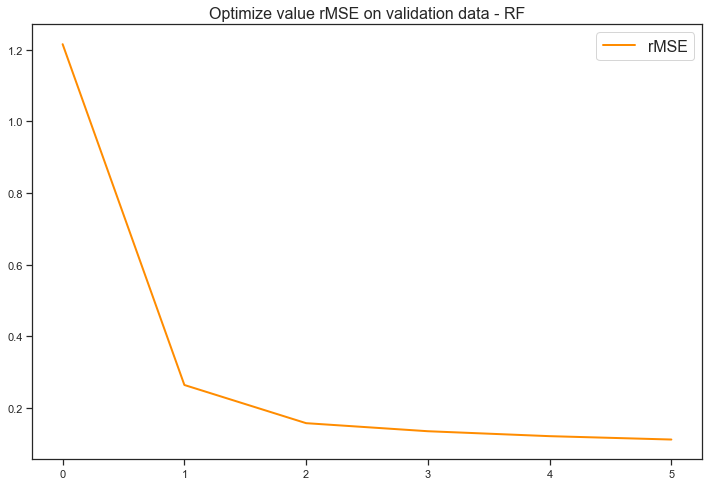

In [44]:
n = 5000 # sô lần lặp
showOutput = False
saveToFile = False
Optimize_RF(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR, n , X_cross, y_cross, showOutput)

 
 Fistround best RSquared: 0.969714 
 ,after running linear regression 5000 different times with different test and training combinations
Value alpha:  0.0


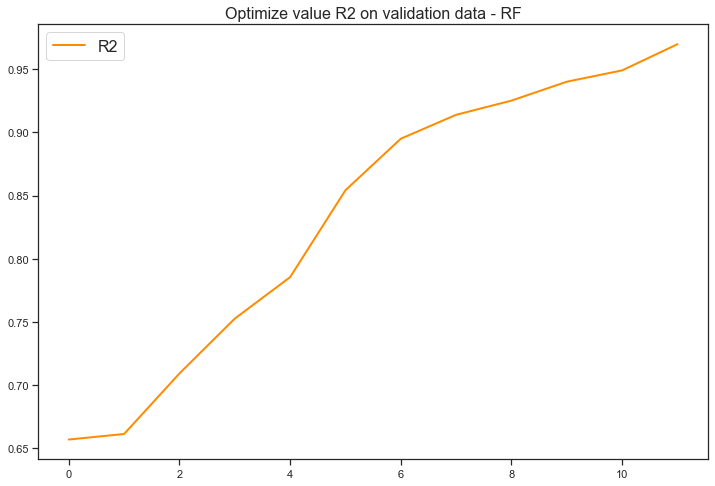

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [45]:
n = 5000 # sô lần lặp
Optimize_RF(LineaReggressionMetrics.R_SQUARED, n, X_cross, y_cross, showOutput)


 
 Fistround best MAE: 0.058533 
 ,after running linear regression 5000 different times with different test and training combinations
Value alpha:  0.0


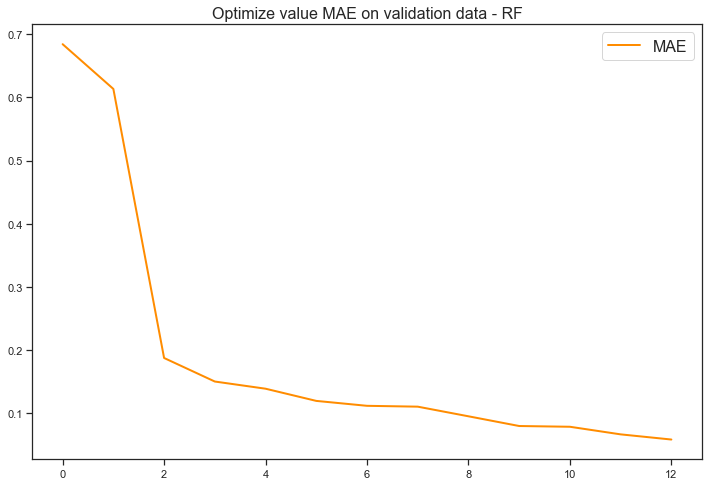

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [46]:
n = 5000 # sô lần lặp
Optimize_RF(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR, n, X_cross, y_cross, showOutput)

In [48]:
Optimize_RF2(10, X_cross, y_cross)

TIME:  0
Price ICO 0x (REAL: 1.08):  [1.84618513]
Price ICO modum (REAL: 2.79):  [2.61333001]
Price ICO crypto20 (REAL: 0.9876):  [1.85775786]
Value rMSE:  2.491737995599476
Value R2:  -0.3459810374166099
Value MAE:  1.4224865227272743
**********************************************************************************


TIME:  1
Price ICO 0x (REAL: 1.08):  [2.18259007]
Price ICO modum (REAL: 2.79):  [3.03732307]
Price ICO crypto20 (REAL: 0.9876):  [0.97910471]
Value rMSE:  2.3376182376976846
Value R2:  -0.18462628836474404
Value MAE:  1.3343907208484862
**********************************************************************************


TIME:  2
Price ICO 0x (REAL: 1.08):  [2.06563704]
Price ICO modum (REAL: 2.79):  [4.07047876]
Price ICO crypto20 (REAL: 0.9876):  [0.96640344]
Value rMSE:  2.7169812581904123
Value R2:  -0.6003223753023139
Value MAE:  1.5920599025681839
**********************************************************************************


TIME:  3
Price ICO 0x (REAL: 1.08)

# Đánh giá Random Forest


## LOAD MODEL TỐI ƯU ĐÃ LƯU VÀ TÍNH TOÁN HIỆU NĂNG

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. Fro

Predicted value when using best model rMSE: 
[ 8.757234    0.23357435  6.64468652  0.23655412  0.47813071  0.374667
  0.05840886  2.57136651  2.12265397  2.22910275  0.62107919  0.43888529
  1.54084885  9.38426409  0.42446097  2.91187209  0.06445167  0.16631727
  7.14081927 13.57308925  0.70339876  0.76981444]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


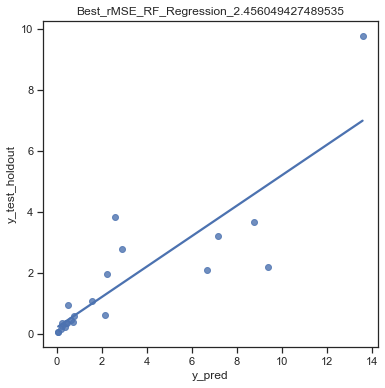

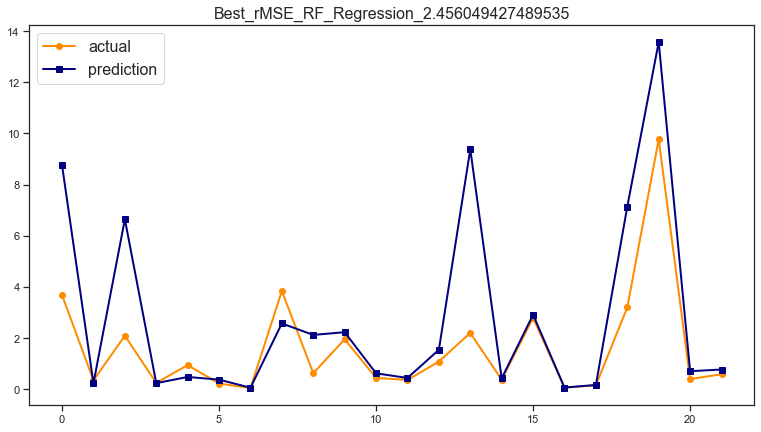

Regression coefficient when using best model rMSE: 
[2.75280098e-01 3.61817662e-01 8.93537894e-02 4.87729679e-03
 4.03680035e-02 5.55305017e-03 2.58269717e-02 1.88674305e-02
 2.01083004e-03 3.51010071e-05 2.23203484e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 9.03348835e-08 5.44368098e-06
 1.42108440e-06 3.69332802e-07 4.30744707e-05 1.02720731e-08
 7.67616994e-04 1.04166604e-05 7.73852204e-09 0.00000000e+00
 2.10288307e-05 1.47449349e-05 1.03066400e-06 1.78297965e-06
 2.87061367e-04 7.45985953e-05 2.85095514e-08 3.38247223e-03
 4.65746188e-09 1.52214635e-10 0.00000000e+00 3.67755885e-08
 2.18768469e-07 0.00000000e+00 0.00000000e+00 9.38223717e-07
 1.32963330e-10 1.70982276e-02 5.26383409e-04 3.15877862e-08
 6.43980945e-10 9.66295843e-10 5.06657194e-02 2.05543659e-02
 5.21632631e-06 0.00000000e+00 0.00000000e+00 7.17597255e-07
 1.81411746e-09 3.44832034e-09 4.18561310e-10 2.20213223e-07
 0.00000000e+00 2.25504134e-04 0.00000000e+00 5.24335754e-07
 6.03713313e-04 2.02319499e-03 1.

In [50]:
#fileName1 = '/content/drive/MyDrive/DoAn2/ICO_FINAL/RESULT/bestRegressionModel_RF_MEAN_ABSOLUTE_ERROR.sav'
fileName1 = 'D:/Tunf/NOO/HK1_2022_2023_(Ki1_nam4)/DA2/ICO_FINAL/CODE/RESULT/bestRegressionModel_RF_MEAN_ABSOLUTE_ERROR.sav'


bestRegression_rMSE_RF = joblib.load(fileName1)
saveToFile = True
y_pred_holdout_rMSE = None
y_pred_holdout_R2 = None
y_pred_holdout_MAE = None

holdOutMeanSquaredError = None
holdOutValidationR2Squared = None
holdOutMeanABError = None

if(bestRegression_rMSE_RF):
    y_pred_holdout_rMSE = bestRegression_rMSE_RF.predict(X_test_holdout)  
    holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE))
    print("Predicted value when using best model rMSE: ")
    print(y_pred_holdout_rMSE)   
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_rMSE_RF_Regression_" + str(holdOutMeanSquaredError)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_rMSE, title=heading, lw=2)
    print("Regression coefficient when using best model rMSE: ")  
    #print(bestRegression_rMSE_RF.score(y_test_holdout, y_pred_holdout_rMSE))
    print(bestRegression_rMSE_RF.feature_importances_)
    print("************************************************************************************************")
    print("\n")
    


Predicted value when using best model rMSE: 
[ 7.9969019   0.19340629  6.94931973  0.32169355  0.51922135  0.3344256
  0.0485093   2.45109779  2.10466759  2.21868418  0.50718349  0.66312654
  1.53815526  9.28244137  0.51666877  3.07897941  0.0575107   0.21418361
  7.20756075 14.66706307  0.79559322  1.05965129]
Actual value: 
[3.68     0.348067 2.09     0.245655 0.942803 0.220648 0.046815 3.84
 0.625696 1.95     0.443365 0.361564 1.08     2.2      0.371102 2.79
 0.062887 0.150417 3.2      9.77     0.396967 0.584651]


c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


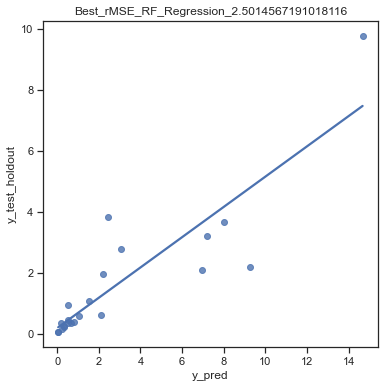

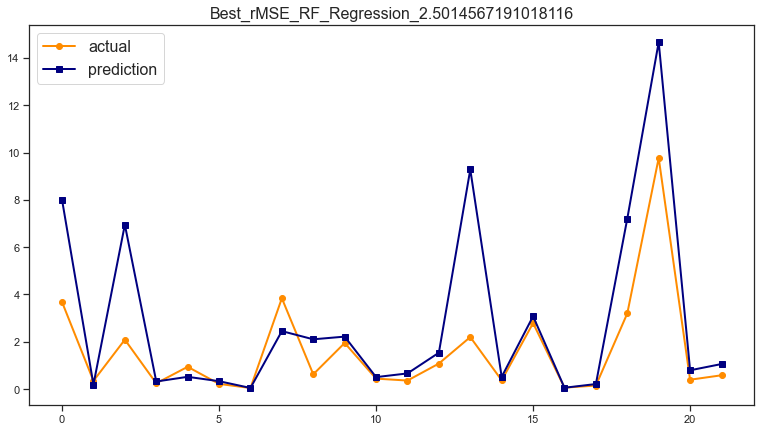

Regression coefficient when using best model rMSE: 
[3.71983867e-01 3.31118156e-01 6.93803466e-02 3.83153965e-03
 2.46691058e-02 8.32912949e-03 4.31890396e-02 1.28416900e-02
 1.28067000e-03 5.23380061e-05 3.47274190e-06 5.87257448e-07
 8.88221915e-09 0.00000000e+00 3.41255979e-08 2.75870744e-05
 6.66560148e-06 6.17699913e-06 1.75585980e-05 0.00000000e+00
 4.23518020e-04 9.93765963e-06 9.75494898e-10 2.44172210e-11
 5.18128270e-05 1.85631324e-06 1.49628300e-06 1.24474171e-07
 1.39375939e-03 1.60315582e-05 1.20289542e-07 9.73343485e-03
 3.62955054e-08 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.11424114e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 7.96526133e-12 1.72852855e-02 1.79535731e-04 0.00000000e+00
 0.00000000e+00 7.42626645e-06 2.41029923e-02 2.80155191e-03
 1.99645915e-06 0.00000000e+00 2.20865869e-07 1.93561849e-06
 7.10433904e-08 1.79095981e-09 4.14603414e-10 1.84770127e-07
 0.00000000e+00 2.18701890e-04 0.00000000e+00 0.00000000e+00
 2.85487207e-03 2.44568567e-04 1.

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. Fro

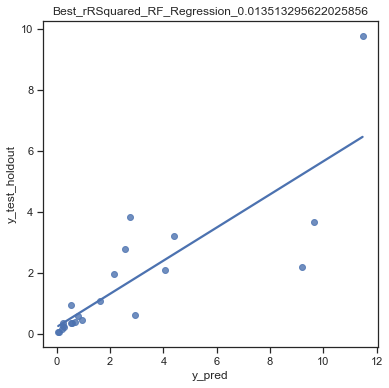

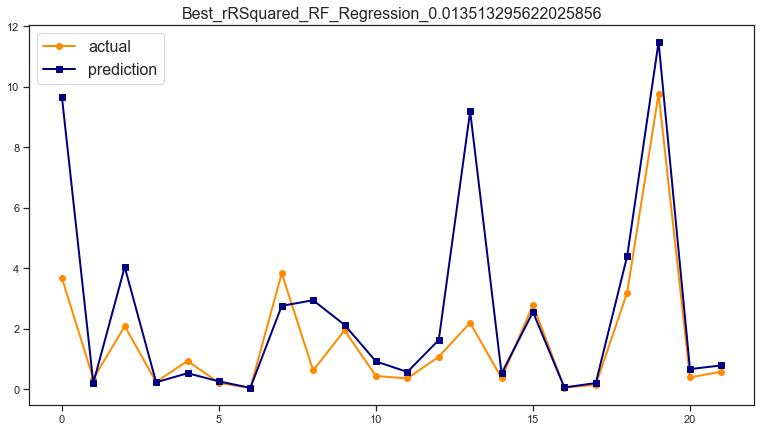

Regression coefficient when using best model R2: 
[3.02993618e-01 1.95516474e-01 1.71109267e-01 4.29971727e-03
 5.31408168e-02 8.17064491e-03 5.29674997e-02 7.41830388e-02
 5.64963112e-04 8.31160444e-05 3.77118198e-05 2.60553249e-08
 1.41589090e-08 0.00000000e+00 3.15917401e-07 4.02090111e-06
 0.00000000e+00 1.60143547e-07 1.09200554e-09 4.38889555e-08
 7.94185134e-06 2.53578057e-06 0.00000000e+00 2.36717847e-11
 2.93878006e-05 8.89162921e-07 4.89442955e-08 1.36039546e-06
 1.40538588e-03 1.31757505e-04 7.57249503e-08 3.98051021e-03
 1.35516197e-08 3.98368519e-09 0.00000000e+00 1.34203112e-09
 1.86121754e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.03217325e-09 3.10968606e-02 2.72283769e-04 9.77804715e-08
 9.94627644e-09 3.36257001e-05 9.48259139e-03 3.15463648e-02
 4.20452574e-08 9.70733857e-08 2.70119820e-06 9.55446839e-08
 1.97025972e-08 0.00000000e+00 9.30771941e-09 0.00000000e+00
 0.00000000e+00 1.49886957e-04 0.00000000e+00 5.70064354e-06
 5.89875875e-04 2.49234556e-04 1.34

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. Fro

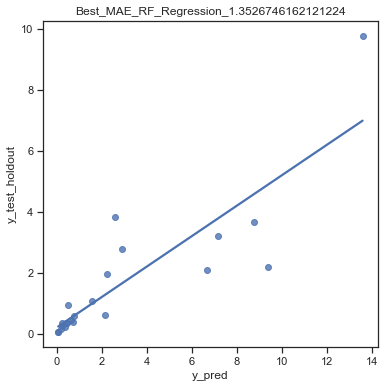

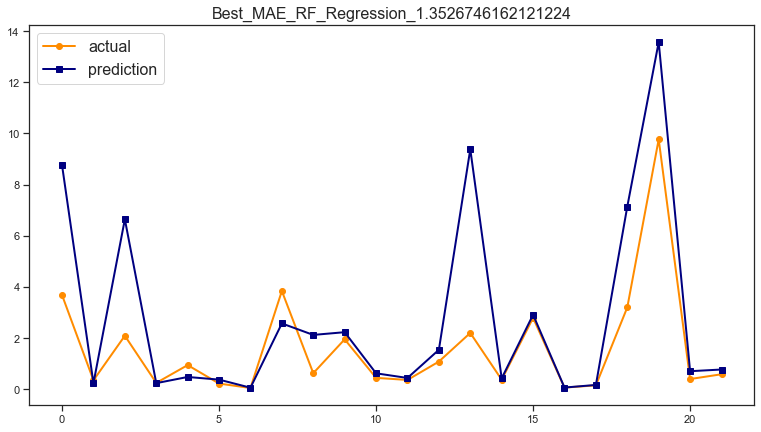

Regression coefficient when using best model MAE: 
[3.02993618e-01 1.95516474e-01 1.71109267e-01 4.29971727e-03
 5.31408168e-02 8.17064491e-03 5.29674997e-02 7.41830388e-02
 5.64963112e-04 8.31160444e-05 3.77118198e-05 2.60553249e-08
 1.41589090e-08 0.00000000e+00 3.15917401e-07 4.02090111e-06
 0.00000000e+00 1.60143547e-07 1.09200554e-09 4.38889555e-08
 7.94185134e-06 2.53578057e-06 0.00000000e+00 2.36717847e-11
 2.93878006e-05 8.89162921e-07 4.89442955e-08 1.36039546e-06
 1.40538588e-03 1.31757505e-04 7.57249503e-08 3.98051021e-03
 1.35516197e-08 3.98368519e-09 0.00000000e+00 1.34203112e-09
 1.86121754e-07 0.00000000e+00 0.00000000e+00 0.00000000e+00
 2.03217325e-09 3.10968606e-02 2.72283769e-04 9.77804715e-08
 9.94627644e-09 3.36257001e-05 9.48259139e-03 3.15463648e-02
 4.20452574e-08 9.70733857e-08 2.70119820e-06 9.55446839e-08
 1.97025972e-08 0.00000000e+00 9.30771941e-09 0.00000000e+00
 0.00000000e+00 1.49886957e-04 0.00000000e+00 5.70064354e-06
 5.89875875e-04 2.49234556e-04 1.3

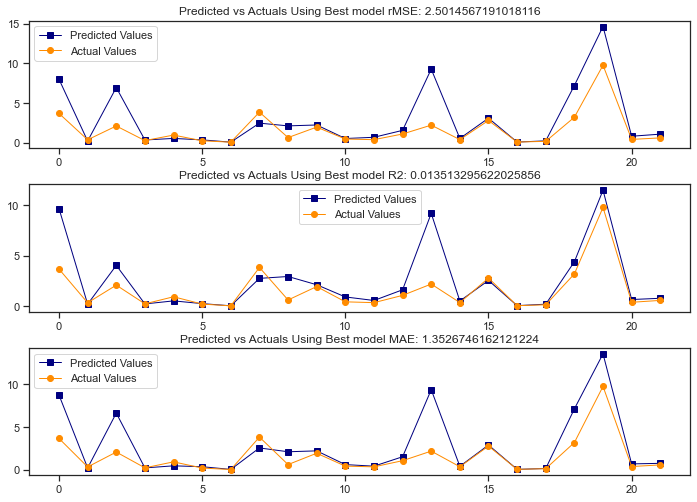

In [51]:
# LOAD MODEL SỬ DỤNG HỒI QUY RF - rMSE
fileName1 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + ".sav"
#fileName1 = '/content/drive/MyDrive/DoAn2/ICO_FINAL/RESULT/bestRegressionModel_RF_MEAN_ABSOLUTE_ERROR.sav'

bestRegression_rMSE_RF = joblib.load(fileName1)
saveToFile = True
y_pred_holdout_rMSE = None
y_pred_holdout_R2 = None
y_pred_holdout_MAE = None

holdOutMeanSquaredError = None
holdOutValidationR2Squared = None
holdOutMeanABError = None

if(bestRegression_rMSE_RF):
    y_pred_holdout_rMSE = bestRegression_rMSE_RF.predict(X_test_holdout)  
    holdOutMeanSquaredError = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE))
    print("Predicted value when using best model rMSE: ")
    print(y_pred_holdout_rMSE)   
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_rMSE_RF_Regression_" + str(holdOutMeanSquaredError)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout, y_pred_holdout_rMSE, heading, saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_rMSE, title=heading, lw=2)
    print("Regression coefficient when using best model rMSE: ")  
    print(bestRegression_rMSE_RF.feature_importances_)
    print("************************************************************************************************")
    print("\n")

# LOAD MODEL SỬ DỤNG HỒI QUY RF - R2
fileName3 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.R_SQUARED.name) + ".sav"
bestRegression_rSquared_RF = loadModel(fileName3)

if(bestRegression_rSquared_RF):
    y_pred_holdout_R2 = bestRegression_rSquared_RF.predict(X_test_holdout)   
    holdOutValidationR2Squared = r2_score(y_test_holdout, y_pred_holdout_R2)
    print("Predicted value when using best model R2: ")
    print(y_pred_holdout_R2)
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_rRSquared_RF_Regression_" + str(holdOutValidationR2Squared)
    plotExpectedVsPredictedOutput2(y_test_holdout, y_pred_holdout_R2,heading, saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout, y_pred_holdout_R2,heading, saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_R2, title=heading, lw=2)
    print("Regression coefficient when using best model R2: ")
    print(bestRegression_rSquared_RF.feature_importances_) 
    print("************************************************************************************************")
    print("\n")

fileName4 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + ".sav"
bestRegression_MAE_RF = loadModel(fileName4)

if(bestRegression_MAE_RF):
    y_pred_holdout_MAE = bestRegression_MAE_RF.predict(X_test_holdout)   
    holdOutMeanABError = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE)
    print("Predicted value when using best model MAE: ")
    print(y_pred_holdout_MAE)
    print("Actual value: ")
    print(y_test_holdout)
    heading = "Best_MAE_RF_Regression_" + str(holdOutMeanABError)
    plotExpectedVsPredictedOutput2(y_test_holdout,y_pred_holdout_MAE,heading,saveToFile)
    #plotExpectedVsPredictedOutput(y_test_holdout,y_pred_holdout_MAE,heading,saveToFile)
    line_plot(y_test_holdout, y_pred_holdout_MAE, title=heading, lw=2)    
    print("Regression coefficient when using best model MAE: ")
    print(bestRegression_rSquared_RF.feature_importances_)

plotResult(y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE, rMSE = str(holdOutMeanSquaredError), 
           R2 = str(holdOutValidationR2Squared), MAE = str(holdOutMeanABError))

## **SỬ DỤNG MODEL ĐỂ DỰ ĐOÁN - GIÁ TRỊ CỦA ICO SAU 6 THÁNG**

Price of 3 ICO when using best mode rMSE
Predicted value of ICO 0x (real price: 1.08) after 6 months:  [1.53815526]
Predicted value of ICO modum (real price: 2.79) after 6 months:  [3.07897941]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months:  [0.90049002]
Value rMSE, R2, MAE of best model rMSE
Value rMSE:  2.5014567191018116
Value R2:  -0.35650118714405266
Value MAE:  1.4213840678030314
*******************************************************************************************


Price of 3 ICO when using best mode R2
Predicted value of ICO 0x (real price: 1.08) after 6 months:  [1.63250319]
Predicted value of ICO modum (real price: 2.79) after 6 months:  [2.55486638]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months:  [0.89335847]
Value rMSE, R2, MAE of best model R2
Value rMSE:  2.1331850044031677
Value R2:  0.013513295622025856
Value MAE:  1.0987291286969698
****************************************************************************************

c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 1.0.2 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\asus\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version

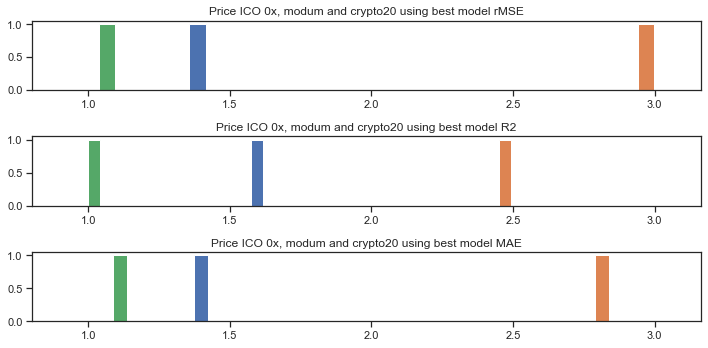

In [53]:
# LOAD MODEL VỚI GIÁ TRỊ rMSE LÀ TỐT NHẤT rF
fileName1 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + ".sav"
bestRegression_rMSE_RF = joblib.load(fileName1)
price_rMSE = []
price_R2 = []
price_MAE = []
#price_usd,price_btc,total_supply,market_cap_usd,available_supply,usd_raised,eth_price_launch,btc_price_launch,ico_duration,month,day,country
ico_0x = np.array([1.71456, 0.00019931, 1000000000, 905793616, 528295082, 24000000, 297.63, 3420.4, 7, 8, 9, 182])
ico_modum = np.array([2.36319, 0.00027471, 27266200, 43166501, 18266200, 13500000, 383.47, 4701.76, 21, 9, 1, 33])
ico_crypto20 = np.array([1.68825, 0.00019625, 40656082, 66992446, 39681591, 38222081, 308.89, 4369.35, 54, 10, 7, 196])
ico_wanchin = np.array([6.71639, 0.00078075, 210000000, 712961540, 106152493, 35704520, 297.48, 4408.46, 1, 10, 3, 182])
y_pred1 = makePrediction(bestRegression_rMSE_RF, ico_0x)
y_pred2 = makePrediction(bestRegression_rMSE_RF, ico_modum)
y_pred3 = makePrediction(bestRegression_rMSE_RF, ico_crypto20)
price_rMSE.append(y_pred1)
price_rMSE.append(y_pred2)
price_rMSE.append(y_pred3)
y_pred_holdout_rMSE = bestRegression_rMSE_RF.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_rMSE))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_rMSE)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_rMSE)
print("Price of 3 ICO when using best mode rMSE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred1)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred2)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred3)
print("Value rMSE, R2, MAE of best model rMSE")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")

# LOAD MODEL VỚI GIÁ TRỊ R2 LÀ TỐT NHẤT
fileName2 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.R_SQUARED.name) + ".sav"
bestRegression_rSquared_RF = joblib.load(fileName2)
y_pred4 = makePrediction(bestRegression_rSquared_RF, ico_0x)
y_pred5 = makePrediction(bestRegression_rSquared_RF, ico_modum)
y_pred6 = makePrediction(bestRegression_rSquared_RF, ico_crypto20)
price_R2.append(y_pred4)
price_R2.append(y_pred5)
price_R2.append(y_pred6)
y_pred_holdout_R2 = bestRegression_rSquared_RF.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_R2))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_R2)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_R2)
print("Price of 3 ICO when using best mode R2")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred4)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred5)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred6)
print("Value rMSE, R2, MAE of best model R2")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")

# LOAD MODEL VỚI GIÁ TRỊ MAE LÀ TỐT NHẤT
fileName3 = "RESULT/" + "bestRegressionModel_RF_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) + ".sav"
bestRegression_MAE_RF = joblib.load(fileName3)
y_pred7 = makePrediction(bestRegression_MAE_RF, ico_0x)
y_pred8 = makePrediction(bestRegression_MAE_RF, ico_modum)
y_pred9 = makePrediction(bestRegression_MAE_RF, ico_crypto20)
price_MAE.append(y_pred7)
price_MAE.append(y_pred8)
price_MAE.append(y_pred9)
y_pred_holdout_MAE = bestRegression_MAE_RF.predict(X_test_holdout) 
rMSE_holdout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout_MAE))
r2_holdout = r2_score(y_test_holdout, y_pred_holdout_MAE)
holdout_MAE  = mean_absolute_error(y_test_holdout, y_pred_holdout_MAE)
print("Price of 3 ICO when using best mode MAE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months: ",y_pred7)
print("Predicted value of ICO modum (real price: 2.79) after 6 months: ",y_pred8)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months: ",y_pred9)
print("Value rMSE, R2, MAE of best model MAE")
print("Value rMSE: ", rMSE_holdout)
print("Value R2: ", r2_holdout)
print("Value MAE: ", holdout_MAE)
print("*******************************************************************************************")
print("\n")
plotPredicted(price_rMSE, price_R2, price_MAE)

# Đánh Giá Random Forest


Price of 3 ICO using best model rMSE
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE:  [1.71842176]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE:  [2.54551639]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE:  [1.03911078]
Value rMSE, R2, MAE of best model rMSE
Value rMSE:  2.847275472691648
Value R2:  -0.7574912283957353
Value MAE:  1.2092949178160528


*************************************************************************************
Price of 3 ICO using best model R2
Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2:  [1.70223752]
Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2:  [2.72644286]
Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2:  [1.02398441]
Value rMSE, R2, MAE of best model R2
Value rMSE:  2.285951568513681
Value R2:  -0.13283913066575836
Value MAE:

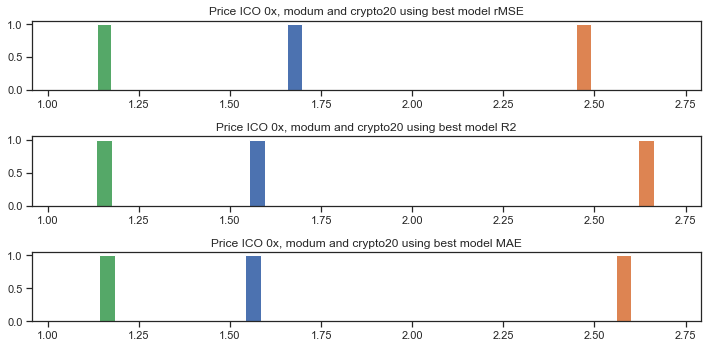

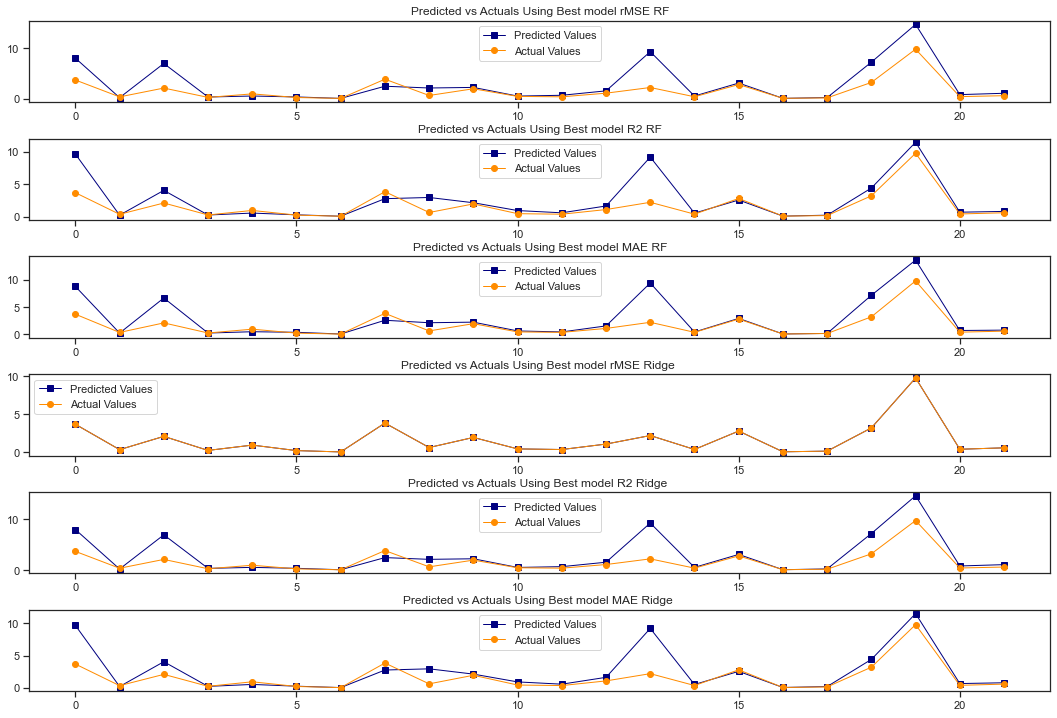

In [61]:
# Load model with best rMse and make prediction
plotNNrMSE = []
plotNNR2 = []
plotNNMAE = []
fileName = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.ROOT_MEAN_SQUARED_ERROR.name) + ".sav"
best_ridge_RMSE = joblib.load(fileName)

fileName1 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.R_SQUARED.name)+ ".sav"
bestRegressionModel_Ridge_rS = joblib.load(fileName1)

fileName2 = "RESULT/" + "bestRegressionModel_Ridge_" + str(LineaReggressionMetrics.MEAN_ABSOLUTE_ERROR.name) +".sav"
bestRegressionModel_Ridge_MAE = joblib.load(fileName2)

y_pred =  makePrediction(best_ridge_RMSE, ico_0x)
y_pred1 = makePrediction(best_ridge_RMSE, ico_modum)
y_pred2 = makePrediction(best_ridge_RMSE, ico_crypto20)
plotNNrMSE.append(y_pred)
plotNNrMSE.append(y_pred1)
plotNNrMSE.append(y_pred2)
y_pred_holdout = best_ridge_RMSE.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model rMSE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model rMSE: ",y_pred)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model rMSE: ",y_pred1)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model rMSE: ",y_pred2)
print("Value rMSE, R2, MAE of best model rMSE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestRegressionModel_Ridge_rS, ico_0x)
y_pred4 = makePrediction(bestRegressionModel_Ridge_rS, ico_modum)
y_pred5 = makePrediction(bestRegressionModel_Ridge_rS, ico_crypto20)
plotNNR2.append(y_pred3)
plotNNR2.append(y_pred4)
plotNNR2.append(y_pred5)
y_pred_holdout = bestRegressionModel_Ridge_rS.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model R2")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model R2: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model R2: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model R2: ",y_pred5)
print("Value rMSE, R2, MAE of best model R2")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout) 
print("\n")       
print("*************************************************************************************")

y_pred3 = makePrediction(bestRegressionModel_Ridge_MAE, ico_0x)
y_pred4 = makePrediction(bestRegressionModel_Ridge_MAE, ico_modum)
y_pred5 = makePrediction(bestRegressionModel_Ridge_MAE, ico_crypto20)
plotNNMAE.append(y_pred3)
plotNNMAE.append(y_pred4)
plotNNMAE.append(y_pred5)
y_pred_holdout = bestRegressionModel_Ridge_MAE.predict(X_test_holdout)
R2coefficientHoldout = r2_score(y_test_holdout, y_pred_holdout)
rMeanSquaredErrorHoldout = sqrt(mean_squared_error(y_test_holdout, y_pred_holdout))
meanAbsoluteErrorHoldout= mean_absolute_error(y_test_holdout, y_pred_holdout)
print("Price of 3 ICO using best model MAE")
print("Predicted value of ICO 0x (real price: 1.08) after 6 months using best model MAE: ",y_pred3)
print("Predicted value of ICO modum (real price: 2.79) after 6 months using best model MAE: ",y_pred4)
print("Predicted value of ICO crypto20 (real price: 0.9786) after 6 months using best model MAE: ",y_pred5)
print("Value rMSE, R2, MAE of best model MAE")
print("Value rMSE: ", rMeanSquaredErrorHoldout)
print("Value R2: ", R2coefficientHoldout)
print("Value MAE: ", meanAbsoluteErrorHoldout)  
print("\n")       
print("*************************************************************************************")
plotPredicted(plotNNrMSE, plotNNR2, plotNNMAE)
plotResult2(y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE, 
                y_test_holdout, y_pred_holdout_rMSE, y_pred_holdout_R2, y_pred_holdout_MAE)